# Development: Integrate ORCA with Milestone Tracking

In [5]:
import sys
sys.path.append('../')
from panav.environment.env import MultiTunnelEnv
from panav.hybrid import HybridGraph
from panav.util import flowtime,makespan
from panav.PBS.PBS import PBS
from panav.TrafficAwarePlanning import TAHP
from panav.sequential import sequential_planning
from panav.SAMP.solvers import Tube_Planning



from time import time
import pickle as pkl

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import sys
sys.path.append('../')

sys.path.append('../../')
import numpy as np
import cvxpy as cp
from matplotlib import pyplot as plt
from panav.environment.env import NavigationEnv
from panav.environment.region import Box2DRegion, PolygonRegion
from panav.environment.utils import box_2d_center

from panav.viz import draw_env


import shapely

from panav.ORCA import ORCA_Agent
from panav.util import unique_tx

%load_ext autoreload
%autoreload 2

%load_ext snakeviz

In [6]:

bloating_r = 0.5
vmax = 1.0

N = 100


results = []

env_name = "MultiTunnel"


env = MultiTunnelEnv(n_tunnel = 4, tunnel_width = bloating_r*2.5,limits=[(-50,50),(-50,50)], N_agent = N)
HG = HybridGraph(env,bloating_r)


Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-15


/Users/tianpengzhang/opt/miniconda3/envs/PA-Nav/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


In [7]:
from panav.TrafficAwarePlanning import traffic_aware_HG_plan
paths = traffic_aware_HG_plan(HG)

ref_plan = [np.array([HG.node_loc(u) for u in path]).T for path in paths]

In [8]:
from joblib import Parallel, delayed

plans = ref_plan

tau = 1 # The safe time interval. Can be generously long.
exec_tau = 1.0 * tau 
agents = set(np.arange(N))
start_locs = env.starts
goal_locs = env.goals
# The execution time of ORCA velocity.
# Should be much shorter than the safe interval tau.

pos = []

v_prefs = [np.zeros(start_locs[0].shape) for a in agents]

protocol = 0

orcas = [ORCA_Agent(protocol,tau,bloating_r,vmax,p,v) 
         for p,v in zip(start_locs,v_prefs)]

curr_wp_index = [0 for a in agents]

opt_worker = Parallel(n_jobs=8)
for _ in range(200):
    pos.append(np.array([a.p for a in orcas]))
       
    # Compute the preferred velocity.
 
    def calc_pref(agent):

        wp = plans[agent][:,curr_wp_index[agent]]
        # See if the agent has reached the current waypoint.
        if np.linalg.norm(wp-orcas[agent].p)<= bloating_r:  
            curr_wp_index[agent] = \
            np.min([curr_wp_index[agent]+1,   
                    plans[agent].shape[1]-1
                                  ])
            
            wp = plans[agent][:,curr_wp_index[agent]]
            
        to_wp = wp-orcas[agent].p
        print("agent",agent,"to_wp",to_wp,'curr_wp_index',curr_wp_index[agent])
        v_prefs[agent] = to_wp/tau if tau*vmax > np.linalg.norm(to_wp) else vmax *  to_wp/(np.linalg.norm(to_wp)+1e-5)
    
    # opt_worker(delayed(calc_pref)(agent) for agent in agents)
    for agent in agents:
        calc_pref(agent)
    # Update v_opt
    for a in agents:
        orcas[a].update_v_opt(v_prefs[a])
    
    # Compute the safe velocity.
    for a in agents:      
        print('update v for agent',a)
        orcas[a].update_v(v_prefs[a],env.obstacles,
                        [orcas[b] for b in agents-set([a])])
    
    # Execute the safe velocity.
    all_reached = True
    
    for a in agents:
        dist2goal = np.linalg.norm(orcas[a].p - goal_locs[a])
        print(a,dist2goal)

        if dist2goal>=1*bloating_r:
            v = np.array([0,0]) if orcas[a].v is None else orcas[a].v
            print(orcas[a].v)
            orcas[a].p += v*exec_tau
            all_reached = False
    if all_reached:
        break

agent 0 to_wp [-32.36875 -29.875  ] curr_wp_index 1
agent 1 to_wp [-32.36875 -28.24235] curr_wp_index 1
agent 2 to_wp [-32.36875 -26.60969] curr_wp_index 1
agent 3 to_wp [-32.36875 -24.97704] curr_wp_index 1
agent 4 to_wp [-32.36875 -23.34439] curr_wp_index 1
agent 5 to_wp [-32.36875 -21.71173] curr_wp_index 1
agent 6 to_wp [-32.36875 -20.07908] curr_wp_index 1
agent 7 to_wp [-32.36875 -18.44643] curr_wp_index 1
agent 8 to_wp [-32.36875 -16.81378] curr_wp_index 1
agent 9 to_wp [-32.36875 -15.18112] curr_wp_index 1
agent 10 to_wp [-32.36875 -13.54847] curr_wp_index 1
agent 11 to_wp [-32.36875 -11.91582] curr_wp_index 1
agent 12 to_wp [-32.36875 -10.28316] curr_wp_index 1
agent 13 to_wp [-32.36875  -8.65051] curr_wp_index 1
agent 14 to_wp [-32.36875  -7.01786] curr_wp_index 1
agent 15 to_wp [-32.36875  -5.3852 ] curr_wp_index 1
agent 16 to_wp [-32.36875  -3.75255] curr_wp_index 1
agent 17 to_wp [-32.36875  -2.1199 ] curr_wp_index 1
agent 18 to_wp [-32.36875 -20.73724] curr_wp_index 1
age

KeyboardInterrupt: 

/Users/tianpengzhang/opt/miniconda3/envs/PA-Nav/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


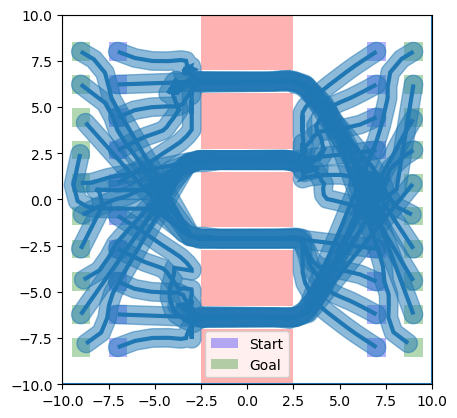

In [11]:

from shapely.plotting import plot_polygon, plot_line
pos = np.array(pos)

ax = plt.gca()
draw_env(env,[],ax)

for a in agents:
    line = shapely.geometry.LineString(pos[:,a,:])
    dilated = line.buffer(bloating_r)

    plot_line(line, ax=ax, add_points=False, linewidth=3)
    plot_polygon(dilated, ax=ax, add_points=False, alpha=0.5)

In [12]:
from panav.viz import animation
from IPython.display import HTML, display

dt = exec_tau

pos_to_ani = [pos[:,a,:].T for a in agents]
anim = animation(env, pos_to_ani, bloating_r, dt = dt)
display(HTML(anim.to_jshtml()))
plt.close() 